# Techno-economic analysis (TEA) <a class="anchor" id="top"></a>

* **Prepared by:**

    - Yalin Li

* **Covered topics:**

    - Techno-economic analysis (TEA)
        - `TEA`
        - `SimpleTEA`

* **Update date:** 2021-04-27
* `qsdsan` **version:** 0.2.6

To run tutorials in your browser, go to this [Binder page](https://mybinder.org/v2/gh/QSD-Group/QSDsan/main?filepath=%2Fdocs%2Fsource%2Ftutorials).

---
### Note
This tutorial is pending updates (more detailed ones coming soon!)

---

In [2]:
import biosteam as bst
import qsdsan as qs
from qsdsan import sanunits as su
from exposan import bwaise as bw

TEA in `qsdsan` is performed through the `TEA` object in `biosteam`, but a new `SimpleTEA` class (subclass of `TEA`) is added for simpler systems that are more relevant for sanitation-related studies.

For use of `TEA`, follow the [tutorial](https://biosteam.readthedocs.io/en/latest/tutorial/Techno-economic_analysis.html) provided in `biosteam` documents.

## Features of `SimpleTEA`
Here we will focus on some features of `SimpleTEA`.

System: sys1
ins...
[0] U2_toilet_paper
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Tissue  0.000282
[1] U2_flushing_water
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): H2O  0.0231
[2] U2_cleansing_water
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0
[3] U2_desiccant
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0
outs...
[0] U2_excreta
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): NH3      2.78e-05
                    NonNH3   3.72e-05
                    P        9.02e-06
                    K        1.51e-05
                    Mg       6.17e-06
                    Ca       1.81e-05
                    H2O      0.0124
                    ...
[1] U2_leachate
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): NH3  1.74e-05
                    P    1.98e-06
                    K    4.03e-06
                    H2O  0.0448
[2] U2_fugative_CH4
    phase: 'g', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): CH4  4.31e

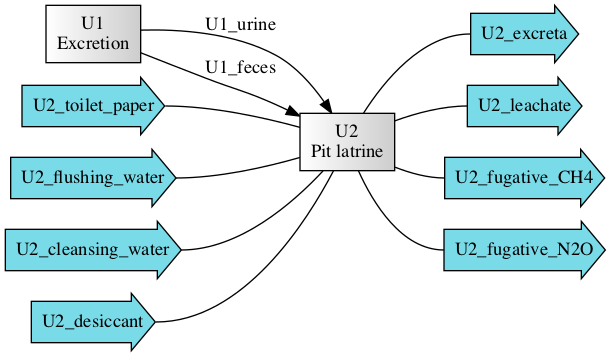

In [3]:
# First we need to construct a system, let's assume we want to look at a pit latrine
cmps = bw.cmps
bst.settings.set_thermo(cmps)
U1 = su.Excretion('U1', outs=('U1_urine', 'U1_feces'))
U2 = su.PitLatrine('U2', ins=(U1-0, U1-1, 'U2_toilet_paper', 'U2_flushing_water',
                              'U2_cleansing_water', 'U2_desiccant'),
                   outs=('U2_excreta', 'U2_leachate', 'U2_fugative_CH4', 'U2_fugative_N2O'),
                   N_user=4, N_toilet=2,
                  decay_k_COD=3, decay_k_N=3, max_CH4_emission=0.25)
sys1 = bst.System('sys1', path=(U1, U2))
sys1.simulate()
sys1.show()
sys1.diagram('thorough')

In [4]:
#  There is no costs associated with the Excretion unit
U1.results()

,Excretion,Units,U1
Total purchase cost,,USD,0
Utility cost,,USD/hr,0


In [5]:
# But the PitLatrine unit has capital and operating costs
U2.results()

Pit latrine                                      Units       U2
Design              Number of users per toilet                4
                    Parallel toilets                          2
                    Emptying period                 yr      0.8
                    Single pit volume               m3     3.66
                    Single pit area                 m2      0.8
                    Single pit depth                       4.57
                    Cement                          kg  1.4e+03
                    Sand                            kg 6.34e+03
                    Gravel                          kg 2.56e+03
                    Brick                           kg      454
                    Plastic                         kg     20.2
                    Steel                           kg     67.2
                    Wood                            m3     0.38
                    Excavation                      m3     7.31
Purchase cost       Total toilets                  USD      898
Total purchase cost                                USD      898
Utility cost                                    USD/hr        0
Additional OPEX                                 USD/hr  0.00513

In [6]:
# Note that all SanUnit has a add_OPEX attribute where you can specify the OPEX cost per hr
# in addition to materials and utilities.
U2.add_OPEX

{'Additional OPEX': 0.0051255707762557084}

In [7]:
# With some assumptions, we can calculate costs associated with this system like
tea1 = qs.SimpleTEA(system=sys1, discount_rate=0.05, lifetime=10)
tea1.show()

SimpleTEA: sys1
NPV  : -1,245 USD at 5.0% discount rate
EAC  : 184 USD/yr
CAPEX: 898 USD (annualized to 139 USD/yr)
AOC  : 45 USD/yr


In [8]:
# Or you directly access the net present value (NPV), equivalent annual cost (EAC),
# capital expenditure (CAPEX, or total capital cost), and annual operating cost (AOC)
tea1.EAC

183.8401886376576

In [9]:
# Currency depends on the setting of qsdsan
tea1.currency == qs.currency

True

In [10]:
# The following will return an error
# tea1.currency = 'euro'

In [11]:
qs.currency = 'euro'
tea1.show()

SimpleTEA: sys1
NPV  : -1,245 euro at 5.0% discount rate
EAC  : 184 euro/yr
CAPEX: 898 euro (annualized to 139 euro/yr)
AOC  : 45 euro/yr


[Back to top](#top)